<img src = "https://raw.githubusercontent.com/touchaee/touchaee.github.io/master/images/Project-Capstone.png">
<h1 align = center>Where to open a new Thai restaurant in New York?</h1>

## Table of Contents
* [1. Introduction: Business Problem](#introduction)
* [2. Data](#data)
* [3. Methodology](#methodology)
* [4. Analysis](#analysis)
* [5. Results and Discussion](#results)
* [6. Conclusion](#conclusion)

## 1. Introduction: Business Problem <a name="introduction"></a>

Over the last 20 years, Thai restaurants have been one of the fastest-growing dining categories in New York City. Ever since the advent of places specializing in regional cuisines, often presenting recipes not seen here before, the Thai dining scene has been more exciting than ever before. So that now I have the fiery food of Isan in the northeast, the mellower food of Chiang Mai near the Burmese border, oodles of noodles from Sukhothai, the curries of central and southern Thailand, the urban cuisine of Bangkok, and the Malaysian-leaning food of the peninsula. Our newest arrival is the food of the capital’s Chinatown.
But the pandemic has been tough on Thai restaurants, a one-third have closed, mostly as a result of the pandemic. The good news is that new places have arisen to replace them; in fact, Thai has been most prominent in the category of new restaurants, as will be shown in what follows, along with lots of highly recommended old favorites.

This project aims to **find a location for the opening of a Thai restaurant in NY**, Specifically, this report will be targeted to stakeholders interested in opening a Thai restaurant in New York City.

The first task would be to find the areas lack Thai Restaurants by analyzing restaurant data from FourSquare API and shortlisting an area, where Thai restaurant is not amongst the most common venues.

I will make use of our data science tools to analyze data and focus on the areas and explore its areas and the 10 most common venues in each area so that the best areas where Thai restaurant is not amongst the most common venue can be selected.

## 2. Data <a name="data"></a>

Based on the definition of our problem, the factors that will influence our decision are:
* finding the areas lack Thai Restaurants
* finding the most common nearby venues 
* Choosing the right location

I will be using the geographical coordinates of NY to plot restaurant in a neighborhood that is lack of Thai Restaurant and in the city's vicinity, and finally, cluster our neighborhoods and present our findings.

Following data sources will be needed to extract/generate the required information:

- [**Part 1**: Using a IBM dataset containing the New York Borough, Neighborhood and geometry coordinates](#part1):  A dataset consisting of Borough, Neighborhood, Latitude and Longitude

- [**Part 2**: Gathering Thai Restaurant data for each neighborhood from FoursquareAPI](#part2): Get the venue data that belongs to the neighborhood and borough.

- [**Part 3**: Gathering additional information about the Thai Restaurant for each neighborhood from FoursquareAPI](#part3): Get the additional venue data such as likes, ratings and price.
- [**Part 4:** Gathering additional information about the **Nearby** Venues for each Thai Restaurant from FoursquareAPI](#part4): Get the venue data that nearby Thai restaurants.

- [**Part 5**: Creating a new consolidated dataset of the IBM New York Dataset, along with their Thai restaurant, restaurant detail, and the nearby restaurants.](#part5) Merge all of the dataframes into a single dataframe for further analysis

### Importing all the necessary Libraries

In [1]:
import numpy as np
import pandas as pd
print('Pandas version: ', pd.__version__)

# use the inline backend to generate the plots within the browser
%matplotlib inline 

#Importing Matplot lib and associated packages to perform Data Visualisation and Exploratory Data Analysis
import matplotlib as mpl
import matplotlib.pyplot as plt

#mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

#Importing folium to visualise Maps and plot based on Lat and Lng
import folium

#Requests to request web pages by making get requests to FourSquare REST Client
import requests

#To normalise data returned by FourSquare API
from pandas.io.json import json_normalize

#Importing KMeans from SciKit library to Classify neighborhoods into clusters
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

#Importing itertools for visualize
from itertools import cycle, islice

#Use to find sse
from numpy import matlib as mb

print('Libraries imported')

Pandas version:  1.0.1
Matplotlib version:  3.1.0
Libraries imported


### **Part 1:** Using a IBM dataset containing the New York Borough, Neighborhood and geometry coordinates<a name="part1"></a>


####  New York Dataset

Properties of the New York dataset

*   Borough - Recorded borough
*   Neighborhood - Recorded neighborhood
*   Latitude - Recorded latitude
*   Longitude - Recorded longitude


Data set URL: https://cocl.us/new_york_dataset

In [2]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        # get Borough and Neighborhood
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        # get Latitude and Longitude
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [3]:
df = get_new_york_data()
df.shape

(306, 4)

In [4]:
df.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [5]:
# Create dataframe image for Medium
import six

def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

In [ ]:
ax = render_mpl_table(df.head(), header_columns=0, col_width=4.0)
fig = ax.get_figure()
fig.savefig('data_part1.png')

### **Part 2:** Gathering Thai Restaurant data for each neighborhood from FoursquareAPI<a name="part2"></a>

#### Define a function to intract with FourSquare API
get top 200 venues within a radius of 1500 metres for a given latitude and longitude. Below function will return us the venue id , venue name, category, latitude and longitude.

In [6]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=200
    CLIENT_ID = 'RZDYH51XGA4ZLDY3HLI5UWLNWEKUMMLKGYABRT2CGO12XCBZ' # changed my Foursquare ID
    CLIENT_SECRET = '4ZPM33XMBRGDBG4KWJZJ2VS5CXDGYGAVGWJ2QS3QSRDPGLWE' # changed Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_lat = row['venue']['location']['lat']
            venue_lng = row['venue']['location']['lng']
            venue_details.append([venue_id,venue_name,venue_category,venue_lat,venue_lng])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category','Venue_lat','Venue_lng']
    df = pd.DataFrame(venue_details,columns=column_names)
    print("done")
    return df

#### Define a function to get venue details.

In [7]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'RZDYH51XGA4ZLDY3HLI5UWLNWEKUMMLKGYABRT2CGO12XCBZ' # changed my Foursquare ID
    CLIENT_SECRET = '4ZPM33XMBRGDBG4KWJZJ2VS5CXDGYGAVGWJ2QS3QSRDPGLWE' # changed Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_price_message = venue_data['price']['message']
        venue_price_tier = venue_data['price']['tier']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips,venue_price_message,venue_price_tier])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips','Price_message','Price_tier']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

#### Collect Thai restaurant data for each neighborhood and borough

In [ ]:
# prepare neighborhood list that contains Thai resturants
column_names=['Borough', 'Neighborhood', 'ID','Name', 'Category','Venue_lat','Venue_lng']
Thai_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in df.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    Thai_resturants = venues[venues['Category'] == 'Thai Restaurant']   
    print(f'({count}/{len(df)}) Thai Resturants in {Neighborhood}, {Borough} : {str(len(Thai_resturants))}')
    for resturant_detail in Thai_resturants.values.tolist():
        id, name , category, venue_lat, venue_lng = resturant_detail
        Thai_rest_ny = Thai_rest_ny.append({'Borough': Borough,
                                            'Neighborhood': Neighborhood, 
                                            'ID': id,
                                            'Name' : name,
                                            'Category' : category,
                                            'Venue_lat' : venue_lat,
                                            'Venue_lng' : venue_lng
                                               }, ignore_index=True)
    count+=1

Save dataframe as csv named _'thai_rest_ny.csv'_

In [ ]:
#Thai_rest_ny.to_csv('thai_rest_ny.csv')

In [8]:
Thai_rest_ny = pd.read_csv('thai_rest_ny.csv', index_col = 0)

In [9]:
Thai_rest_ny.head()

,Borough,Neighborhood,ID,Name,Category,Venue_lat,Venue_lng
0,Bronx,Riverdale,4b94a4a2f964a520787f34e3,Nam Thai,Thai Restaurant,40.886388,-73.910025
1,Bronx,Kingsbridge,4b94a4a2f964a520787f34e3,Nam Thai,Thai Restaurant,40.886388,-73.910025
2,Manhattan,Marble Hill,4a739e29f964a520f5dc1fe3,Siam Square,Thai Restaurant,40.878796,-73.916701
3,Bronx,Country Club,4b4c90d3f964a52046b626e3,Honey's Thai Pavilion,Thai Restaurant,40.847845,-73.831320
4,Bronx,Parkchester,5585c948498e0bd8a8a706f1,Thai Cuisine,Thai Restaurant,40.838048,-73.863917


In [ ]:
ax = render_mpl_table(Thai_rest_ny.head(), header_columns=0, col_width=4.0)
fig = ax.get_figure()
fig.savefig('data_part2.png')

In [ ]:
print(Thai_rest_ny.shape)

#### Further Cleaning the data by dropping rows with duplicated data

In [10]:
Thai_rest_ny.drop_duplicates(subset = ['ID'], inplace = True)
Thai_rest_ny.reset_index(inplace = True, drop = True)

In [11]:
Thai_rest_ny.head()

,Borough,Neighborhood,ID,Name,Category,Venue_lat,Venue_lng
0,Bronx,Riverdale,4b94a4a2f964a520787f34e3,Nam Thai,Thai Restaurant,40.886388,-73.910025
1,Manhattan,Marble Hill,4a739e29f964a520f5dc1fe3,Siam Square,Thai Restaurant,40.878796,-73.916701
2,Bronx,Country Club,4b4c90d3f964a52046b626e3,Honey's Thai Pavilion,Thai Restaurant,40.847845,-73.831320
3,Bronx,Parkchester,5585c948498e0bd8a8a706f1,Thai Cuisine,Thai Restaurant,40.838048,-73.863917
4,Bronx,Pelham Bay,57097b8b498e5431176ca914,Tana Thai Restaurant,Thai Restaurant,40.851395,-73.843658


In [12]:
print(Thai_rest_ny.shape)

(99, 7)


We got 99 Thai Resturants across New York City

### **Part 3:** Gathering additional information about the Thai Restaurant for each neighborhood from FoursquareAPI<a name="part3"></a>

In [ ]:
# prepare neighborhood list that contains Thai resturants
column_names=['Borough', 'Neighborhood', 'ID', 'Name', 'Venue_lat', 'Venue_lng', 'Likes', 'Rating', 'Tips', 'Price_message', 'Price_tier']
Thai_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in Thai_rest_ny.values.tolist():
    Borough, Neighborhood, ID, Name, Category, Venue_lat, Venue_lng = row
    try:
        venue_details = get_venue_details(ID)
        print(venue_details)
        id, name, likes, rating, tips, price_message, price_tier = venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print(f'({count}/{len(Thai_rest_ny)}), done')
    Thai_rest_stats_ny = Thai_rest_stats_ny.append({'Borough': Borough,
                                                    'Neighborhood': Neighborhood, 
                                                    'ID': id,
                                                    'Name' : name,
                                                    'Venue_lat' : Venue_lat,
                                                    'Venue_lng' : Venue_lng,
                                                    'Likes' : likes,
                                                    'Rating' : rating,
                                                    'Tips' : tips,
                                                    'Price_message': price_message,
                                                    'Price_tier': price_tier
                                                   }, ignore_index=True)
    count+=1

In [ ]:
#Thai_rest_stats_ny.to_csv('thai_rest_stats_ny.csv')

In [13]:
Thai_rest_stats_ny = pd.read_csv('thai_rest_stats_ny.csv', index_col = 0)

In [14]:
Thai_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Venue_lat,Venue_lng,Likes,Rating,Tips,Price_message,Price_tier
0,Bronx,Riverdale,4b94a4a2f964a520787f34e3,Nam Thai,40.886388,-73.910025,3,7.1,5,Moderate,2
1,Manhattan,Marble Hill,4a739e29f964a520f5dc1fe3,Siam Square,40.878796,-73.916701,15,7.3,13,Moderate,2
2,Bronx,Country Club,4b4c90d3f964a52046b626e3,Honey's Thai Pavilion,40.847845,-73.831320,19,7.3,27,Cheap,1
3,Bronx,Parkchester,5585c948498e0bd8a8a706f1,Thai Cuisine,40.838048,-73.863917,17,7.2,1,Moderate,2
4,Bronx,Pelham Bay,0,0,40.851395,-73.843658,0,0.0,0,Moderate,2


In [ ]:
ax = render_mpl_table(Thai_rest_stats_ny.head(), header_columns=0, col_width=4.0)
fig = ax.get_figure()
fig.savefig('data_part3.png')

In [ ]:
Thai_rest_stats_ny.info()

In [15]:
Thai_rest_stats_ny[Thai_rest_stats_ny.ID == '0'].shape[0]

6

There is 6 restauratants that I cannot retrieve additional information

Let's drop that 6 rows

In [16]:
Thai_rest_stats_ny.drop(Thai_rest_stats_ny.loc[Thai_rest_stats_ny['ID'] == '0'].index, inplace=True)

#### Convert object columns into float for further analysis

In [17]:
Thai_rest_stats_ny['Likes'] = Thai_rest_stats_ny['Likes'].astype('float64')
Thai_rest_stats_ny['Rating'] = Thai_rest_stats_ny['Rating'].astype('float64')
Thai_rest_stats_ny['Tips'] = Thai_rest_stats_ny['Tips'].astype('float64')
Thai_rest_stats_ny['Price_tier'] = Thai_rest_stats_ny['Price_tier'].astype('float64')
Thai_rest_stats_ny.describe()

,Venue_lat,Venue_lng,Likes,Rating,Tips,Price_tier
count,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000
mean,40.730355,-73.931024,98.763441,8.078495,35.849462,1.913978
std,0.056323,0.070761,153.280816,0.742916,54.916131,0.350649
min,40.590823,-74.157463,3.000000,6.200000,1.000000,1.000000
25%,40.692654,-73.976934,16.000000,7.600000,6.000000,2.000000
50%,40.742850,-73.944202,31.000000,8.200000,12.000000,2.000000
75%,40.761291,-73.887552,87.000000,8.600000,34.000000,2.000000
max,40.886388,-73.721676,766.000000,9.400000,358.000000,3.000000


In [18]:
Thai_rest_stats_ny[['ID', 'Venue_lat', 'Venue_lng']]

,ID,Venue_lat,Venue_lng
0,4b94a4a2f964a520787f34e3,40.886388,-73.910025
1,4a739e29f964a520f5dc1fe3,40.878796,-73.916701
2,4b4c90d3f964a52046b626e3,40.847845,-73.831320
3,5585c948498e0bd8a8a706f1,40.838048,-73.863917
6,50e8d45ae4b06202fbe39b08,40.623236,-74.028173
...,...,...,...
94,57c169e3498e784947e307aa,40.725861,-73.992533
95,4afca7e0f964a520d02422e3,40.757275,-73.968541
96,49cfd074f964a520ce5a1fe3,40.743142,-73.954021
97,57e83df3498eebbe238cb36f,40.739118,-73.990579


### **Part 4:** Gathering additional information about the **Nearby** Venues for each Thai Restaurant from FoursquareAPI<a name="part4"></a>

In [19]:
def get_nearby_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=50
    CLIENT_ID = 'RZDYH51XGA4ZLDY3HLI5UWLNWEKUMMLKGYABRT2CGO12XCBZ' # changed my Foursquare ID
    CLIENT_SECRET = '4ZPM33XMBRGDBG4KWJZJ2VS5CXDGYGAVGWJ2QS3QSRDPGLWE' # changed Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    print("done")
    return df

#### Collect Nearby restaurant data.

In [ ]:
# prepare Thai restaurant data list that contains Thai resturants
column_names=['Thai_res_id', 'ID','Name', 'Category']
nearby_thai_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in Thai_rest_stats_ny[['ID', 'Name', 'Venue_lat', 'Venue_lng']].values.tolist():
    thai_res_id, name, Latitude, Longitude = row
    venues = get_nearby_venues(Latitude, Longitude)
    nearby_restaurant = venues[venues['ID'] != thai_res_id]   
    print(f'({count}/{len(Thai_rest_stats_ny)}) Nearby restaurant {name}: {str(len(nearby_restaurant))}')
    for resturant_detail in nearby_restaurant.values.tolist():
        id, name, category = resturant_detail
        nearby_thai_rest_ny = nearby_thai_rest_ny.append({
                                                        'Thai_res_id' : thai_res_id,
                                                        'ID': id,
                                                        'Name' : name,
                                                        'Category' : category
                                                           }, ignore_index=True)
    count+=1

In [ ]:
#nearby_thai_rest_ny.to_csv('nearby_thai_rest_ny.csv')

In [20]:
nearby_thai_rest_ny = pd.read_csv('nearby_thai_rest_ny.csv', index_col = 0)

In [21]:
nearby_thai_rest_ny.head()

,Thai_res_id,ID,Name,Category
0,4b94a4a2f964a520787f34e3,503cfaffe4b066d39de5005a,Aoyu Japanese Restaurant,Japanese Restaurant
1,4b94a4a2f964a520787f34e3,4b7993cbf964a520c8022fe3,Liebman's Kosher Deli,Deli / Bodega
2,4b94a4a2f964a520787f34e3,590e5d2ce96d0c61de2dcf1d,Cocina Chente,Mexican Restaurant
3,4b94a4a2f964a520787f34e3,4b0b311af964a520642e23e3,Palace of Japan,Japanese Restaurant
4,4b94a4a2f964a520787f34e3,4f653ac0e4b0bf1012abaf2d,Tin Marin,Tapas Restaurant


In [ ]:
ax = render_mpl_table(nearby_thai_rest_ny.head(), header_columns=0, col_width=5.0)
fig = ax.get_figure()
fig.savefig('data_part4-1.png')

#### Pivoting the table to better understand the data by catergory per restaurant

In [22]:
nearby_thai_rest_ny.groupby(['Thai_res_id', 'Category']).count()['Name'].sort_values(ascending = False)

nearby_thai_rest_cat = pd.pivot_table(nearby_thai_rest_ny,
                               values=['Name'],
                               index=['Thai_res_id'],
                               columns=['Category'],
                               aggfunc=len,
                               fill_value=0)

nearby_thai_rest_cat

Name                     \
Category                 Afghan Restaurant African Restaurant   
Thai_res_id                                                     
3fd66200f964a5204ef11ee3                 0                  0   
4112ca00f964a520ed0b1fe3                 0                  0   
42951180f964a52045241fe3                 0                  0   
453f6ce3f964a520353c1fe3                 0                  0   
457d4c15f964a5201a3f1fe3                 0                  0   
...                                    ...                ...   
5d4f31a92ada380008a49b7f                 0                  0   
5dd9e8cf2e6b8600081ec98d                 0                  0   
5df175e82276e2000744dc8b                 0                  0   
5e46e2ec5791a10008c55728                 0                  0   
5ee66a36459579000887cd2b                 0                  0   

                                                                          \
Category                 American Restaurant Animal Shelter Antique Shop   
Thai_res_id                                                                
3fd66200f964a5204ef11ee3                   3              0            0   
4112ca00f964a520ed0b1fe3                   1              0            0   
42951180f964a52045241fe3                   3              0            0   
453f6ce3f964a520353c1fe3                   2              0            0   
457d4c15f964a5201a3f1fe3                   0              0            0   
...                                      ...            ...          ...   
5d4f31a92ada380008a49b7f                   2              0            0   
5dd9e8cf2e6b8600081ec98d                   0              0            1   
5df175e82276e2000744dc8b                   1              0            0   
5e46e2ec5791a10008c55728                   0              0            0   
5ee66a36459579000887cd2b                   0              0            0   

                                                                         \
Category                 Arcade Arepa Restaurant Argentinian Restaurant   
Thai_res_id                                                               
3fd66200f964a5204ef11ee3      0                1                      0   
4112ca00f964a520ed0b1fe3      0                0                      0   
42951180f964a52045241fe3      0                0                      0   
453f6ce3f964a520353c1fe3      0                0                      0   
457d4c15f964a5201a3f1fe3      0                0                      0   
...                         ...              ...                    ...   
5d4f31a92ada380008a49b7f      0                0                      0   
5dd9e8cf2e6b8600081ec98d      0                0                      0   
5df175e82276e2000744dc8b      0                1                      0   
5e46e2ec5791a10008c55728      0                0                      0   
5ee66a36459579000887cd2b      0                0                      0   

                                                 ...                   \
Category                 Art Gallery Art Museum  ... Video Game Store   
Thai_res_id                                      ...                    
3fd66200f964a5204ef11ee3           0          0  ...                0   
4112ca00f964a520ed0b1fe3           0          0  ...                0   
42951180f964a52045241fe3           0          0  ...                0   
453f6ce3f964a520353c1fe3           0          0  ...                0   
457d4c15f964a5201a3f1fe3           0          0  ...                0   
...                              ...        ...  ...              ...   
5d4f31a92ada380008a49b7f           0          0  ...                0   
5dd9e8cf2e6b8600081ec98d           1          0  ...                0   
5df175e82276e2000744dc8b           1          0  ...                0   
5e46e2ec5791a10008c55728           1          0  ...                0   
5ee66a36459579000887cd2b           0          0  ...          

#### One Hot Encoding to Analyze Each Restaurant

In [23]:
# one hot encoding
nyc_onehot = pd.get_dummies(nearby_thai_rest_ny[['Category']], prefix="", prefix_sep="")

# add restaurant column back to dataframe
nyc_onehot['Thai_res_id'] = nearby_thai_rest_ny['Thai_res_id'] 

# move restaurant column to the first column
fixed_columns = [nyc_onehot.columns[-1]] + list(nyc_onehot.columns[:-1])
nyc_onehot = nyc_onehot[fixed_columns]

nyc_onehot.head()

,Thai_res_id,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,...,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,4b94a4a2f964a520787f34e3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4b94a4a2f964a520787f34e3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4b94a4a2f964a520787f34e3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4b94a4a2f964a520787f34e3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4b94a4a2f964a520787f34e3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
nyc_grouped = nyc_onehot.groupby('Thai_res_id').mean().reset_index()
nyc_grouped

,Thai_res_id,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,...,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,3fd66200f964a5204ef11ee3,0.0,0.0,0.061224,0.0,0.000000,0.0,0.020408,0.0,0.000000,...,0.0,0.0,0.020408,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,4112ca00f964a520ed0b1fe3,0.0,0.0,0.020408,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.020408,0.0,0.0,0.020408,0.020408,0.000000,0.000000,0.000000
2,42951180f964a52045241fe3,0.0,0.0,0.061224,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.040816,0.020408,0.000000,0.000000,0.040816
3,453f6ce3f964a520353c1fe3,0.0,0.0,0.040816,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.020408,0.020408,0.020408,0.000000,0.020408
4,457d4c15f964a5201a3f1fe3,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.020408,0.020408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,5d4f31a92ada380008a49b7f,0.0,0.0,0.040816,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.040816,0.000000,0.000000,0.020408
89,5dd9e8cf2e6b8600081ec98d,0.0,0.0,0.000000,0.0,0.020408,0.0,0.000000,0.0,0.020408,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.061224,0.000000,0.000000,0.000000
90,5df175e82276e2000744dc8b,0.0,0.0,0.020408,0.0,0.000000,0.0,0.020408,0.0,0.020408,...,0.0,0.0,0.000000,0.0,0.0,0.061224,0.000000,0.000000,0.000000,0.040816
91,5e46e2ec5791a10008c55728,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.020408,...,0.0,0.0,0.000000,0.0,0.0,0.040816,0.020408,0.000000,0.020408,0.000000


#### Let's print each restaurant along with the top 3 most common venues

In [25]:
num_top_venues = 3

for res in nyc_grouped['Thai_res_id']:
    print("----"+res+"----")
    temp = nyc_grouped[nyc_grouped['Thai_res_id'] == res].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----3fd66200f964a5204ef11ee3----
               venue  freq
0  Indian Restaurant  0.12
1         Food Truck  0.10
2             Bakery  0.10


----4112ca00f964a520ed0b1fe3----
          venue  freq
0        Bakery  0.10
1  Cocktail Bar  0.08
2    Bagel Shop  0.06


----42951180f964a52045241fe3----
                 venue  freq
0  American Restaurant  0.06
1          Coffee Shop  0.06
2       Ice Cream Shop  0.06


----453f6ce3f964a520353c1fe3----
                 venue  freq
0          Coffee Shop  0.06
1  American Restaurant  0.04
2                  Bar  0.04


----457d4c15f964a5201a3f1fe3----
              venue  freq
0  Greek Restaurant  0.08
1     Deli / Bodega  0.08
2  Sushi Restaurant  0.06


----46b1ef0df964a520a0491fe3----
              venue  freq
0            Bakery  0.08
1       Yoga Studio  0.04
2  Sushi Restaurant  0.04


----476f8da1f964a520044d1fe3----
         venue  freq
0  Yoga Studio  0.08
1         Pier  0.04
2          Gym  0.04


----49cfd074f964a520ce5a1fe3----
  

#### Now let's create the new dataframe and display the top 10 nearby venues for each restaurant.

First, let's write a function to sort the venues in descending order.

In [26]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [27]:
num_top_venues = 10

#for column such as 1st 2nd 3rd 4th ...
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Thai_res_id']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
nearby_venues_sorted = pd.DataFrame(columns=columns)
nearby_venues_sorted['Thai_res_id'] = nyc_grouped['Thai_res_id']

for ind in np.arange(nyc_grouped.shape[0]):
    nearby_venues_sorted.iloc[ind, 1:] = return_most_common_venues(nyc_grouped.iloc[ind, :], num_top_venues)

nearby_venues_sorted.head()

,Thai_res_id,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,3fd66200f964a5204ef11ee3,Indian Restaurant,Food Truck,Bakery,American Restaurant,Filipino Restaurant,Grocery Store,Latin American Restaurant,Thai Restaurant,Tibetan Restaurant,Pub
1,4112ca00f964a520ed0b1fe3,Bakery,Cocktail Bar,Bagel Shop,Optical Shop,Bar,Coffee Shop,Dessert Shop,Gift Shop,Gym / Fitness Center,Kitchen Supply Store
2,42951180f964a52045241fe3,Coffee Shop,American Restaurant,Ice Cream Shop,Yoga Studio,Pizza Place,Bar,Indian Restaurant,Bakery,Café,Wine Bar
3,453f6ce3f964a520353c1fe3,Coffee Shop,Bar,Park,American Restaurant,Bakery,Café,Cocktail Bar,Seafood Restaurant,Caribbean Restaurant,Yoga Studio
4,457d4c15f964a5201a3f1fe3,Deli / Bodega,Greek Restaurant,Sushi Restaurant,Bakery,Bagel Shop,Bar,Italian Restaurant,Gourmet Shop,Salad Place,Sandwich Place


In [ ]:
ax = render_mpl_table(nearby_venues_sorted.head(), header_columns=0, col_width=5.0)
fig = ax.get_figure()
fig.savefig('data_part4-2.png')

### **Part 5**: Creating a new consolidated dataset of the IBM New York Dataset, along with their thai restaurant, restaurant detail and the nearby restaruants.<a name="part5"></a> 

In [29]:
thai_res_nyc_merged = Thai_rest_stats_ny.copy()

# merge thai_res_nyc_merged with Thai_rest_stats_ny to add latitude/longitude for each restaurant
thai_res_nyc_merged = thai_res_nyc_merged.merge(nearby_venues_sorted, left_on = 'ID', right_on = 'Thai_res_id')

#order columns
cols_name = thai_res_nyc_merged.columns.to_list()
cols_order = [2, 3, 0, 1]
cols_order.extend(range(4, thai_res_nyc_merged.shape[1]))
cols_name[:] = [cols_name[i] for i in cols_order]
thai_res_nyc_merged = thai_res_nyc_merged[cols_name]
thai_res_nyc_merged.drop(columns = ['Thai_res_id'], inplace = True)

thai_res_nyc_merged.head() # check the last columns!

,ID,Name,Borough,Neighborhood,Venue_lat,Venue_lng,Likes,Rating,Tips,Price_message,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,4b94a4a2f964a520787f34e3,Nam Thai,Bronx,Riverdale,40.886388,-73.910025,3.0,7.1,5.0,Moderate,...,Pizza Place,Mexican Restaurant,Diner,Bar,Coffee Shop,Japanese Restaurant,Bank,Sandwich Place,Bagel Shop,Burger Joint
1,4a739e29f964a520f5dc1fe3,Siam Square,Manhattan,Marble Hill,40.878796,-73.916701,15.0,7.3,13.0,Moderate,...,Donut Shop,Pizza Place,Park,Coffee Shop,Sandwich Place,Deli / Bodega,Wine Shop,Pharmacy,Gym,Mexican Restaurant
2,4b4c90d3f964a52046b626e3,Honey's Thai Pavilion,Bronx,Country Club,40.847845,-73.831320,19.0,7.3,27.0,Cheap,...,Italian Restaurant,Sandwich Place,Bank,Convenience Store,Bakery,Pharmacy,Donut Shop,Pizza Place,Dive Bar,Gym
3,5585c948498e0bd8a8a706f1,Thai Cuisine,Bronx,Parkchester,40.838048,-73.863917,17.0,7.2,1.0,Moderate,...,Pizza Place,Donut Shop,American Restaurant,Latin American Restaurant,Mobile Phone Shop,Supermarket,Coffee Shop,Kids Store,Bar,Bank
4,50e8d45ae4b06202fbe39b08,Top Thai,Brooklyn,Bay Ridge,40.623236,-74.028173,14.0,7.2,11.0,Moderate,...,Spa,Pizza Place,Cosmetics Shop,Middle Eastern Restaurant,Greek Restaurant,Bakery,Japanese Restaurant,Italian Restaurant,Tea Room,Taco Place


In [ ]:
ax = render_mpl_table(thai_res_nyc_merged.head(), header_columns=0, col_width=5.0)
fig = ax.get_figure()
fig.savefig('data_part5.png')

## 3. Methodology<a name="methodology"></a>

Categorized the methodologysection into two parts:

- [**Exploratory Data Analysis**:](#eda) Visualise the restuarants repots in different New York boroughs to idenity where is the best place to open Thai restuarant. 


- [**Modelling**:](#mdl) To help stakeholders choose the right neighborhood within a borough we will be clustering similar neighborhoods using K - means clustering which is a form of unsupervised machine learning algorithm that clusters data based on predefined cluster size. We will use K-Means clustering to address this problem so as to group data based on existing venues which will help in the decision making process.

###  Exploratory Data Analysis<a name="eda"></a>

##### Total Neighborhood in different Borough

In [30]:
df_count_neigh = df.groupby('Borough').count()['Neighborhood'].sort_values(ascending = False).to_frame()

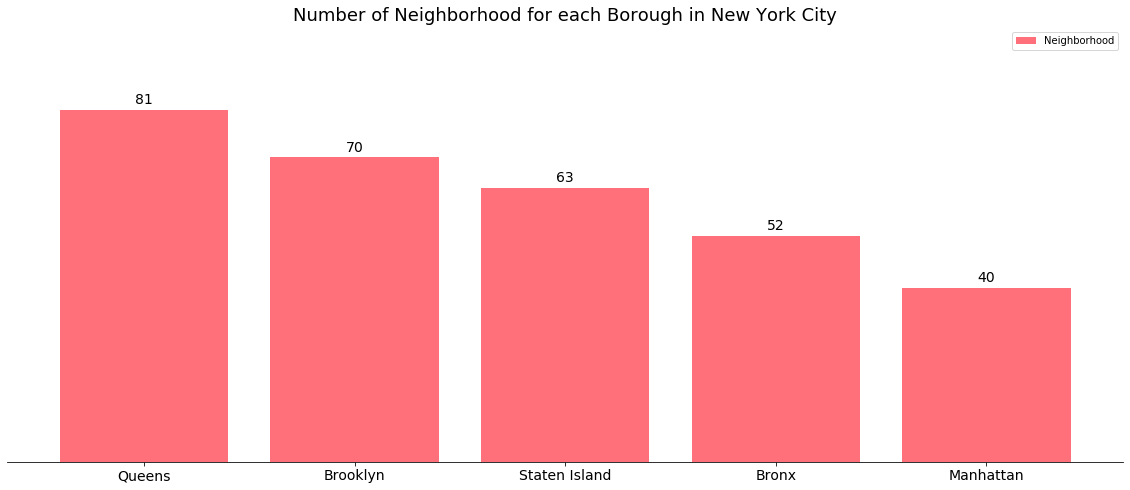

In [31]:
#set ax parameters
figsize = (20, 8)
width = 0.8
title = "Number of Neighborhood for each Borough in New York City"

#Create ax
ax = df_count_neigh.plot(kind = 'bar', figsize = figsize, width = width, color = '#FF707B', rot = 0)
ax.set_ylim(0, 100)

#Text Decoration
ax.set_title(title, fontdict = {'fontsize': 18})
ax.set_xticklabels(df_count_neigh.index, fontdict = {'fontsize': 14})
ax.set_xlabel("")

#Borderless
ax.set_yticklabels("")
ax.get_yaxis().set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

for p in ax.patches:                 
    ax.annotate(
        "{}".format(p.get_height()),
        (p.get_x()+p.get_width()/2., p.get_height()), 
        ha='center',
        va='center', 
        xytext=(0, 10),
        textcoords='offset points', 
        fontsize = 14
    )

'''
#percentage on Movie
plt.annotate('',              # s: str. Will leave it blank for no text
     xy=(0.7, 90),          # place head of the arrow at point (year 2012 , pop 70)
     xytext=(0, 60),      # place base of the arrow at point (year 2008 , pop 20)
     xycoords='data',         # will use the coordinate system of the object being annotated 
     arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='#3790E8', lw=4)
    )

plt.annotate(
    'Queens',
    xy = (0.7, 90),
    fontsize= 16
)
'''

plt.show()
fig = ax.get_figure()
fig.savefig('Graph3-1.png')

We see that Queens has highest number of neighborhoods

##### Total Thai restaurants in different Borough and Neighborhood

In [32]:
df_count_res_borough = Thai_rest_ny.groupby('Borough').count()['ID'].sort_values(ascending = False).to_frame()

In [33]:
df_count_res_neighborhood = Thai_rest_ny.groupby('Neighborhood').count()['ID'].sort_values(ascending = False)[0:5].to_frame()

<Figure size 432x288 with 0 Axes>

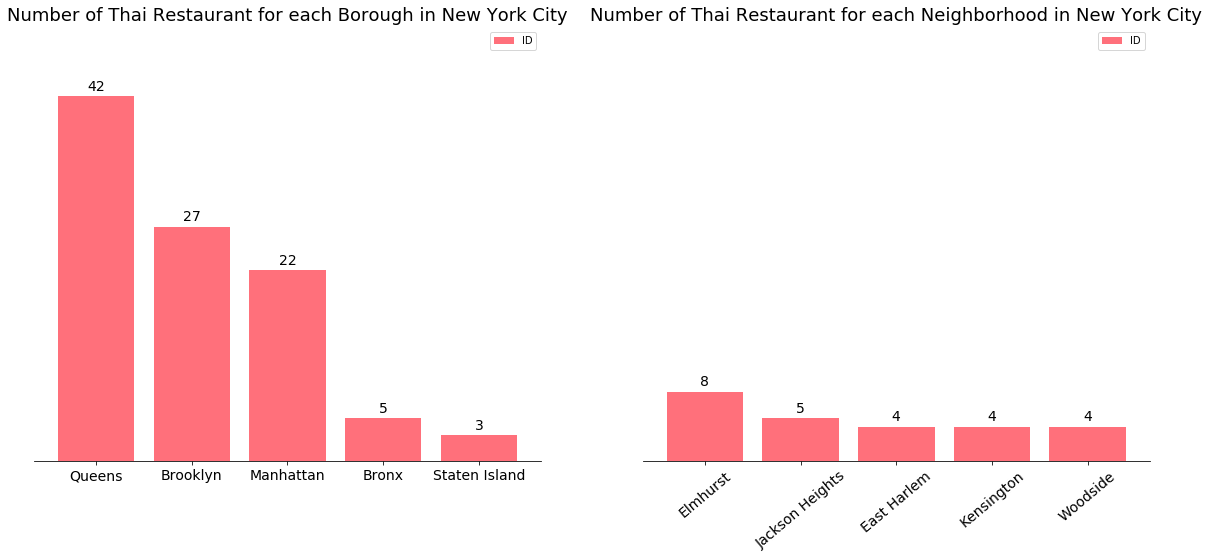

In [34]:
#set ax parameters
figsize = (20, 8)
width = 0.8
title = "Number of Thai Restaurant for each Borough in New York City"

plt.clf()
fig, axes = plt.subplots(nrows=1, ncols=2)

#Plot Borough
#Create ax
ax = df_count_res_borough.plot(kind = 'bar', figsize = figsize, width = width, color = '#FF707B', rot = 0, ax = axes[0])
ax.set_ylim(0, 50)

#Text Decoration
ax.set_title(title, fontdict = {'fontsize': 18})
ax.set_xticklabels(df_count_res_borough.index, fontdict = {'fontsize': 14})
ax.set_xlabel("")

#Borderless
ax.set_yticklabels("")
ax.get_yaxis().set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

for p in ax.patches:                 
    ax.annotate(
        "{}".format(p.get_height()),
        (p.get_x()+p.get_width()/2., p.get_height()), 
        ha='center',
        va='center', 
        xytext=(0, 10),
        textcoords='offset points', 
        fontsize = 14
    )

#Plot Neighborhood   
title = "Number of Thai Restaurant for each Neighborhood in New York City"    
#Create ax
ax = df_count_res_neighborhood.plot(kind = 'bar', figsize = figsize, width = width, color = '#FF707B', rot = 40, ax = axes[1])
ax.set_ylim(0, 50)

#Text Decoration
ax.set_title(title, fontdict = {'fontsize': 18})
ax.set_xticklabels(df_count_res_neighborhood.index, fontdict = {'fontsize': 14})
ax.set_xlabel("")

#Borderless
ax.set_yticklabels("")
ax.get_yaxis().set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

for p in ax.patches:                 
    ax.annotate(
        "{}".format(p.get_height()),
        (p.get_x()+p.get_width()/2., p.get_height()), 
        ha='center',
        va='center', 
        xytext=(0, 10),
        textcoords='offset points', 
        fontsize = 14
    )

plt.show()
fig = ax.get_figure()
fig.savefig('Graph3-2.png')

we see that **Queens** has the most number of Thai restaurants and **Elmgurst Neighborhood** also has the most Thai restaurants.

#### Top 10 Thai rating restaurant in NYC

In [35]:
top_10_res_nyc = thai_res_nyc_merged.groupby(['Borough', 'Neighborhood'])[['Rating']].mean().sort_values('Rating', ascending = False)[:10]
top_10_res_nyc.reset_index(0, inplace = True)
top_10_res_nyc

,Borough,Rating
Neighborhood,,
Noho,Manhattan,9.40
Chinatown,Manhattan,9.35
Lenox Hill,Manhattan,9.20
Flatiron,Manhattan,9.10
Downtown,Brooklyn,9.10
Prospect Lefferts Gardens,Brooklyn,9.00
South Ozone Park,Queens,9.00
Upper East Side,Manhattan,8.90
Yorkville,Manhattan,8.90


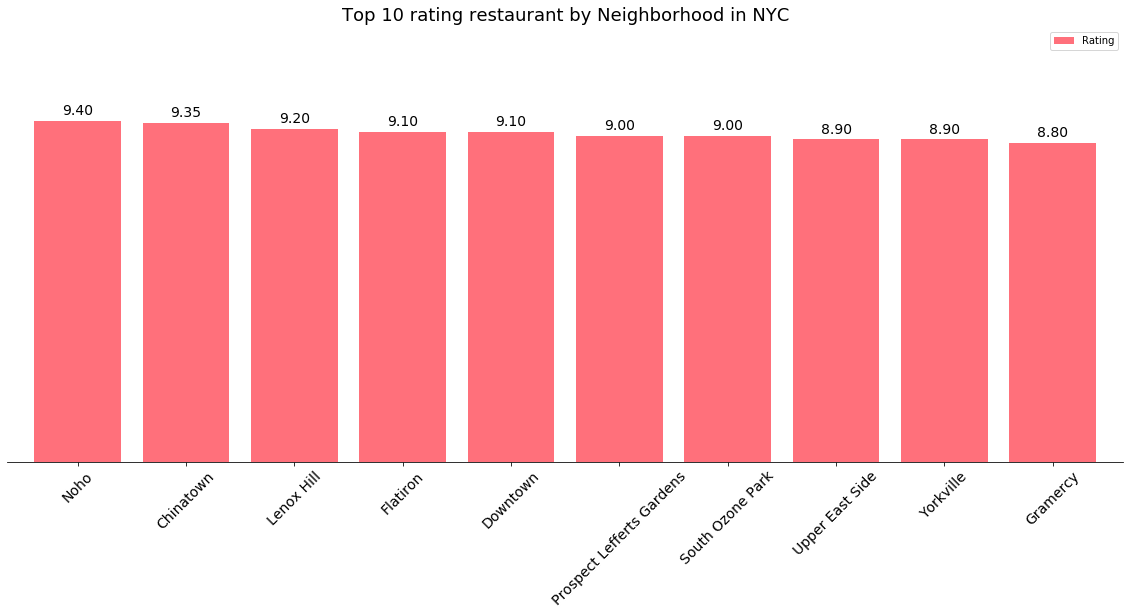

In [37]:
#set ax parameters
figsize = (20, 8)
width = 0.8
title = "Top 10 rating restaurant by Neighborhood in NYC"


#Create ax
ax = top_10_res_nyc.plot(kind = 'bar', figsize = figsize, width = width, color = '#FF707B', rot = 45)
ax.set_ylim(0, 12)

#Text Decoration
ax.set_title(title, fontdict = {'fontsize': 18})
ax.set_xticklabels(top_10_res_nyc.index, fontdict = {'fontsize': 14})
ax.set_xlabel("")

#Borderless
ax.set_yticklabels("")
ax.get_yaxis().set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

for i, p in enumerate(ax.patches):                 
    ax.annotate(
        f"{round(p.get_height(),2):.2f}",
        (p.get_x()+p.get_width()/2., p.get_height()), 
        ha='center',
        va='center', 
        xytext=(0, 10),
        textcoords='offset points', 
        fontsize = 14
    )

plt.show()
fig = ax.get_figure()
fig.savefig('Graph3-3.png')

As you can see Noho has the most average rating score compare with others.

#### Grouping Thai restaurants by location

In [38]:
from folium import plugins


# create map and display it
thai_rest_ny_map = folium.Map(location=[40.71306007524032, -73.94420151920066], zoom_start=11)


# instantiate a mark cluster object for the incidents in the dataframe
incidents = plugins.MarkerCluster().add_to(thai_rest_ny_map)

# loop through the restaurant and add each to the map
for lat, lng, rating, price_message, borough, neighborhood in zip(thai_res_nyc_merged.Venue_lat, thai_res_nyc_merged.Venue_lng, thai_res_nyc_merged.Rating, thai_res_nyc_merged.Price_message, thai_res_nyc_merged.Borough, thai_res_nyc_merged.Neighborhood):
    label = f'rating: {rating}<br>price:  {price_message}<br> Located at {neighborhood}, {borough}'
    folium.features.CircleMarker(
        [lat, lng],
        radius=7, # define how big you want the circle markers to be
        color='white',
        fill=True,
        popup=label,
        fill_color='red',
        fill_opacity=0.6
    ).add_to(incidents)
    
ls = folium.PolyLine([[40.74,-74.00],[40.74,-73.97],[40.77,-73.97],[40.77,-74.00],[40.74,-74.00]], color='red')
ls.add_child(folium.Popup("outline Popup on Polyline"))
ls.add_to(thai_rest_ny_map)

# show map
thai_rest_ny_map

As you can see the area I've highlighted. **This is the area that lacks of Thai restaurants**
5 Neighborhoods
* Manhattan: Gramercy
* Clinton
* Midtown-Midtown South
* Murray Hill-Kips Bay
* Hudson Yards-Chelsea-Flatiron-Union Square

In [ ]:
thai_rest_ny_map.save('exploratory_map_1.html')

### Cluster Neighbourhoods

I've decided to separate 'data pre-processing phase' into 3 parts 

- [**Part 1**: Data preprocessing by create dataframe for clustering](#clusterpart1):  A dataset consisting of Rating (1 - 10), Price_tier (1 - 5) and nearby common venues (0 - 1).

- [**Part 2**: Scaling some features for _K_ Means (Rating and Price is weighted)](#clusterpart2): Scaling two features (Rating & Price tier) with a standard scaler, The reason behind why I choose standard scaler instead of min_max_scaler because I want the range of these 2 features to weighted the model.

- [**Part 3**: Scaling all features for _K_ Means (All features)](#clusterpart3): Scaling all features with max_min_scaler

#### Data preprocessing by create dataframe for clustering <a name = "clusterpart1"></a>

In [39]:
thai_res_nyc_cluster = Thai_rest_stats_ny.copy()

# merge thai_res_nyc_cluster with nyc_grouped to add Rating and Price_tier for each restaurant
thai_res_nyc_cluster = thai_res_nyc_cluster.merge(nyc_grouped, left_on = 'ID', right_on = 'Thai_res_id')

thai_res_nyc_cluster = thai_res_nyc_cluster.drop(columns = list(thai_res_nyc_cluster.columns[i] for i in [0, 1, 2, 3, 4, 5, 6, 8, 9, 11]))

thai_res_nyc_cluster.head() # check the last columns!

,Rating,Price_tier,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,...,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,7.1,2.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.020408,0.0,0.0,0.020408,0.020408,0.000000,0.000000
1,7.3,2.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.040816,0.000000,0.000000,0.020408
2,7.3,1.0,0.0,0.0,0.020408,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.020408,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
3,7.2,2.0,0.0,0.0,0.061224,0.0,0.0,0.0,0.0,0.0,...,0.020408,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.020408,0.000000
4,7.2,2.0,0.0,0.0,0.020000,0.0,0.0,0.0,0.0,0.0,...,0.020000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.020000


In [ ]:
ax = render_mpl_table(thai_res_nyc_cluster.iloc[0:5,0:9], header_columns=0, col_width=4.0)
fig = ax.get_figure()
fig.savefig('preprocessing-1.png')

#### Scaling features for _K_ Means (Rating and Price is weighted) <a name = "clusterpart2"></a>

In [40]:
scaler = StandardScaler()
thai_res_nyc_cluster_scaled = thai_res_nyc_cluster.copy()

#Scaling two features with a standard scaler from -1 to 1
#I used standard scaler instead of min_max_scaler because I want the range of these 2 features to weighted the model.
thai_res_nyc_cluster_scaled[['Rating', 'Price_tier']] = scaler.fit_transform(thai_res_nyc_cluster[['Rating', 'Price_tier']])
thai_res_nyc_cluster_scaled.head()

,Rating,Price_tier,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,...,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,-1.324239,0.246651,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.020408,0.0,0.0,0.020408,0.020408,0.000000,0.000000
1,-1.053571,0.246651,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.040816,0.000000,0.000000,0.020408
2,-1.053571,-2.620662,0.0,0.0,0.020408,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.020408,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
3,-1.188905,0.246651,0.0,0.0,0.061224,0.0,0.0,0.0,0.0,0.0,...,0.020408,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.020408,0.000000
4,-1.188905,0.246651,0.0,0.0,0.020000,0.0,0.0,0.0,0.0,0.0,...,0.020000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.020000


In [ ]:
ax = render_mpl_table(thai_res_nyc_cluster_scaled.iloc[0:5,0:9], header_columns=0, col_width=4.0)
fig = ax.get_figure()
fig.savefig('preprocessing-2.png')

#### Scaling features for _K_ Means (All features) <a name = "clusterpart3"></a>

In [41]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
thai_res_nyc_cluster_scaled_all_features = thai_res_nyc_cluster.copy()

#Scaling two features with a standard scaler from -1 to 1
thai_res_nyc_cluster_scaled_all_features[['Rating', 'Price_tier']] = scaler.fit_transform(thai_res_nyc_cluster_scaled_all_features[['Rating', 'Price_tier']])

cols = thai_res_nyc_cluster_scaled_all_features.drop(['Rating', 'Price_tier'], axis = 1).columns.to_list()
thai_res_nyc_cluster_scaled_all_features[cols] = scaler.fit_transform(thai_res_nyc_cluster_scaled_all_features.drop(['Rating', 'Price_tier'], axis = 1))

thai_res_nyc_cluster_scaled_all_features.head()

,Rating,Price_tier,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,...,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,0.28125,0.5,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,...,0.00,0.000000,0.0,1.0,0.0,0.0,0.333333,0.816327,0.0,0.000
1,0.34375,0.5,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,...,0.00,0.000000,0.0,0.0,0.0,0.0,0.666667,0.000000,0.0,0.250
2,0.34375,0.0,0.0,0.0,0.250,0.0,0.0,0.0,0.0,0.0,...,0.00,0.816327,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000
3,0.31250,0.5,0.0,0.0,0.750,0.0,0.0,0.0,0.0,0.0,...,1.00,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,1.0,0.000
4,0.31250,0.5,0.0,0.0,0.245,0.0,0.0,0.0,0.0,0.0,...,0.98,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.245


In [ ]:
ax = render_mpl_table(thai_res_nyc_cluster_scaled_all_features.iloc[0:5,0:9], header_columns=0, col_width=4.0)
fig = ax.get_figure()
fig.savefig('preprocessing-3.png')

#### Find the best _K_ with elbow method

In [42]:
# Define a function to get sum square error and idx of best point of _k_
def get_sse(dataframe):
    sse = []
    list_k = list(range(1, 10))

    for k in list_k:
        km = KMeans(n_clusters=k)
        km.fit(thai_res_nyc_cluster)
        sse.append(km.inertia_)
        
    nPoints = len(sse)
    allCoord = np.vstack((range(nPoints), sse)).T
    firstPoint = allCoord[0]
    lineVec = allCoord[-1] - allCoord[0]
    lineVecNorm = lineVec / np.sqrt(np.sum(lineVec**2))
    vecFromFirst = allCoord - firstPoint
    scalarProduct = np.sum(vecFromFirst * np.matlib.repmat(lineVecNorm, nPoints, 1), axis=1)
    vecFromFirstParallel = np.outer(scalarProduct, lineVecNorm)
    vecToLine = vecFromFirst - vecFromFirstParallel
    distToLine = np.sqrt(np.sum(vecToLine ** 2, axis=1))
    idxOfBestPoint = np.argmax(distToLine)
    
    return list_k, sse, idxOfBestPoint+1

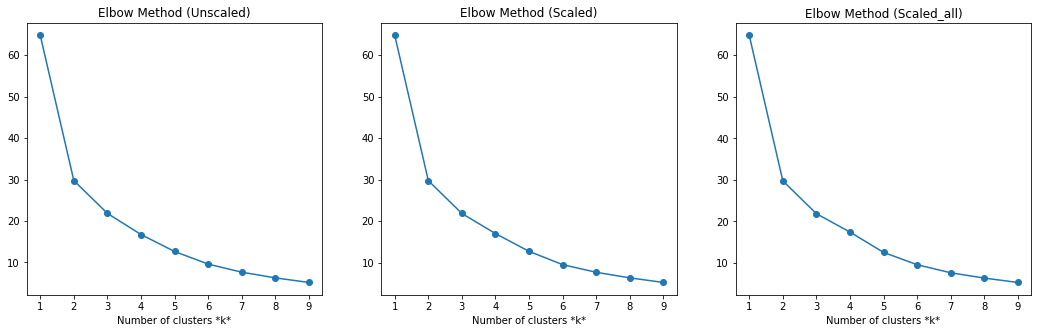

Optimum number of cluster by Elbow method on Unscaled data is 3
Optimum number of cluster by Elbow method on Scaled data is 3
Optimum number of cluster by Elbow method on Scaled all features data is 3


In [43]:
list_k_unscaled, sse_unscaled, idxOfBestPoint_unscaled = get_sse(thai_res_nyc_cluster)
list_k_scaled, see_scaled, idxOfBestPoint_scaled = get_sse(thai_res_nyc_cluster_scaled)
list_k_scaled_all, see_scaled_all, idxOfBestPoint_scaled_all = get_sse(thai_res_nyc_cluster_scaled_all_features)


fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(18, 5)

ax1.plot(list_k_unscaled, sse_unscaled, '-o')
ax1.set_title('Elbow Method (Unscaled)')
ax1.set_xlabel(r'Number of clusters *k*')
ax1.set_label('Sum of squared distance');

ax2.plot(list_k_scaled, see_scaled, '-o')
ax2.set_title('Elbow Method (Scaled)')
ax2.set_xlabel(r'Number of clusters *k*')
ax2.set_label('Sum of squared distance');

ax3.plot(list_k_scaled_all, see_scaled_all, '-o')
ax3.set_title('Elbow Method (Scaled_all)')
ax3.set_xlabel(r'Number of clusters *k*')
ax3.set_label('Sum of squared distance');

plt.show()
print(f"Optimum number of cluster by Elbow method on Unscaled data is {idxOfBestPoint_unscaled}")
print(f"Optimum number of cluster by Elbow method on Scaled data is {idxOfBestPoint_scaled}")
print(f"Optimum number of cluster by Elbow method on Scaled all features data is {idxOfBestPoint_scaled_all}")

fig.savefig('elbow-method.png')

#### Silhouette plot on unscaled data

For n_clusters = 2 The average silhouette_score is : 0.4592030760836139
For n_clusters = 3 The average silhouette_score is : 0.36303255173062055
For n_clusters = 4 The average silhouette_score is : 0.38824608437506075
For n_clusters = 5 The average silhouette_score is : 0.38896826724205313
For n_clusters = 6 The average silhouette_score is : 0.4157611985752017


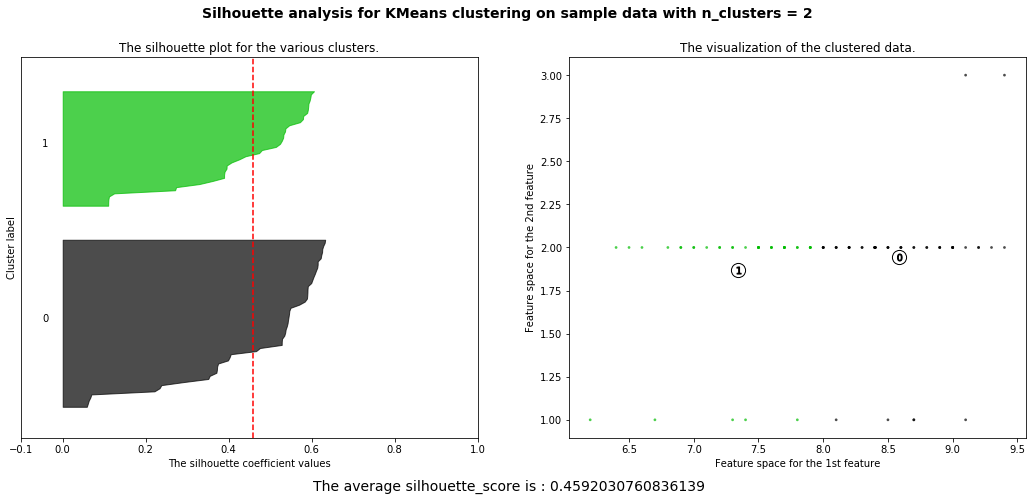

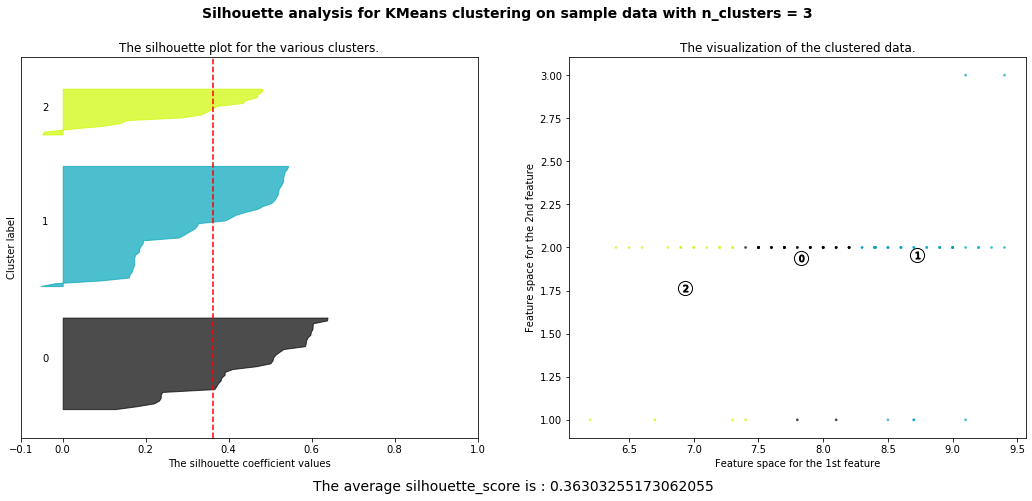

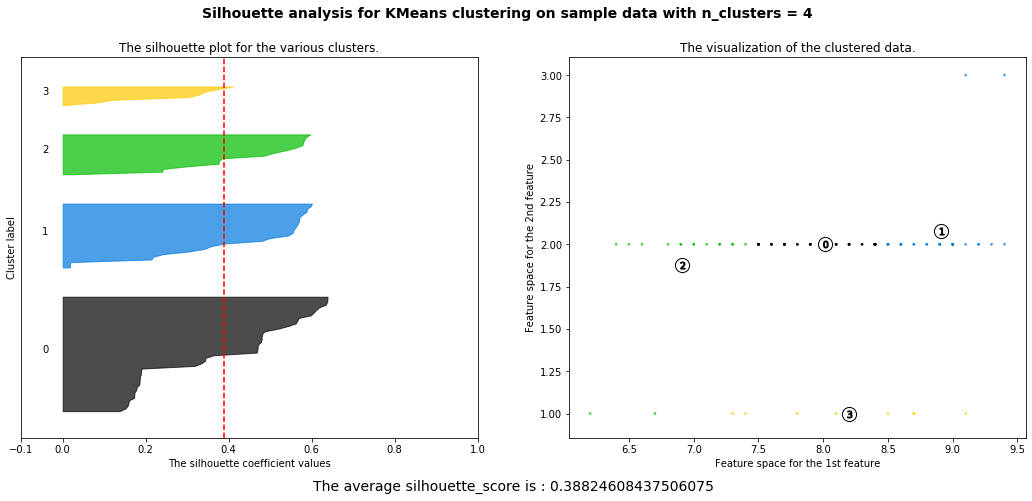

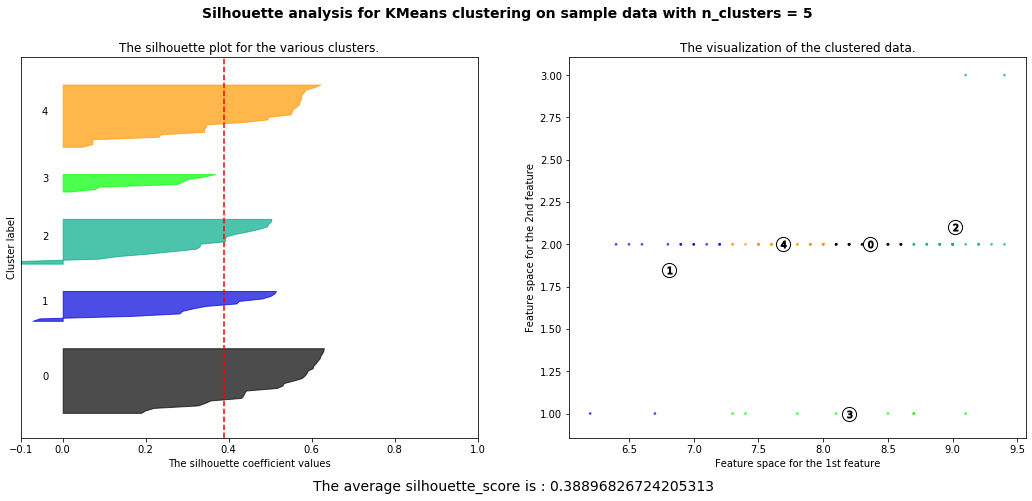

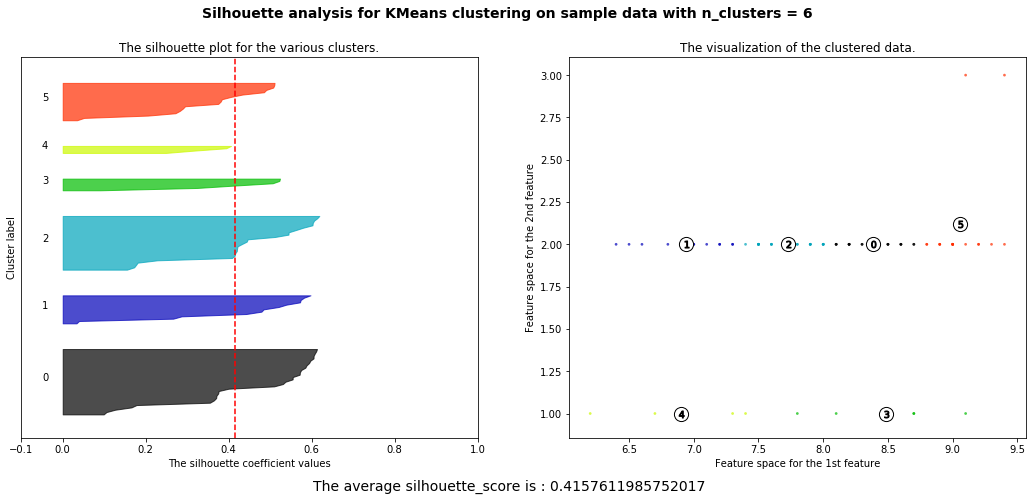

In [44]:
from sklearn.metrics import silhouette_samples, silhouette_score

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(thai_res_nyc_cluster) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(thai_res_nyc_cluster)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(thai_res_nyc_cluster, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(thai_res_nyc_cluster, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors_cluster = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(thai_res_nyc_cluster.Rating.values, thai_res_nyc_cluster.Price_tier.values, marker='.', s=30, lw=0, alpha=0.7,
                c=colors_cluster, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    
    plt.figtext(0.35, 0.02, f'The average silhouette_score is : {silhouette_avg}', fontsize = 14)
    
    
    fig.savefig(f'Silhouette plot on unscaled data_{n_clusters}.png')
plt.show()


#### Silhouette plot on scaled data

For n_clusters = 2 The average silhouette_score is : 0.6215947813533674
For n_clusters = 3 The average silhouette_score is : 0.50723244516246
For n_clusters = 4 The average silhouette_score is : 0.5426377680634848
For n_clusters = 5 The average silhouette_score is : 0.4867970718175185
For n_clusters = 6 The average silhouette_score is : 0.494782143093166


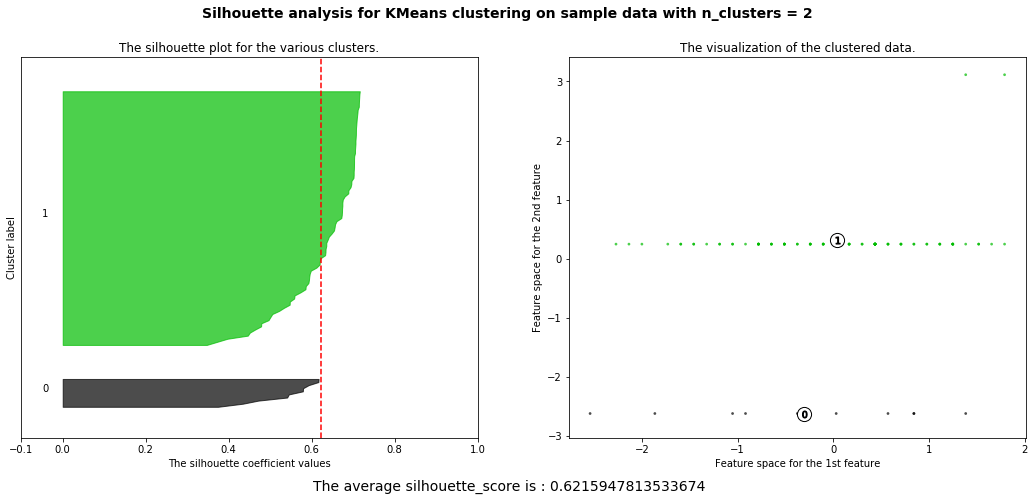

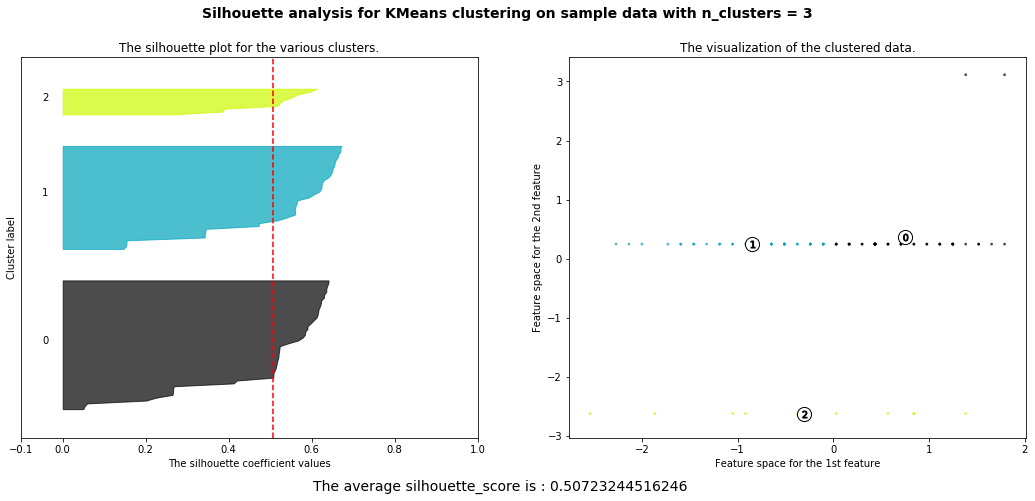

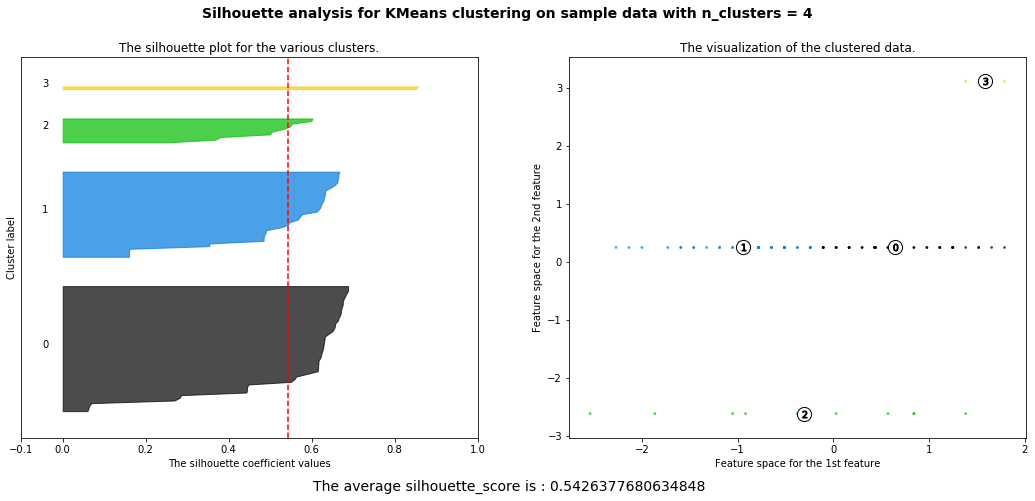

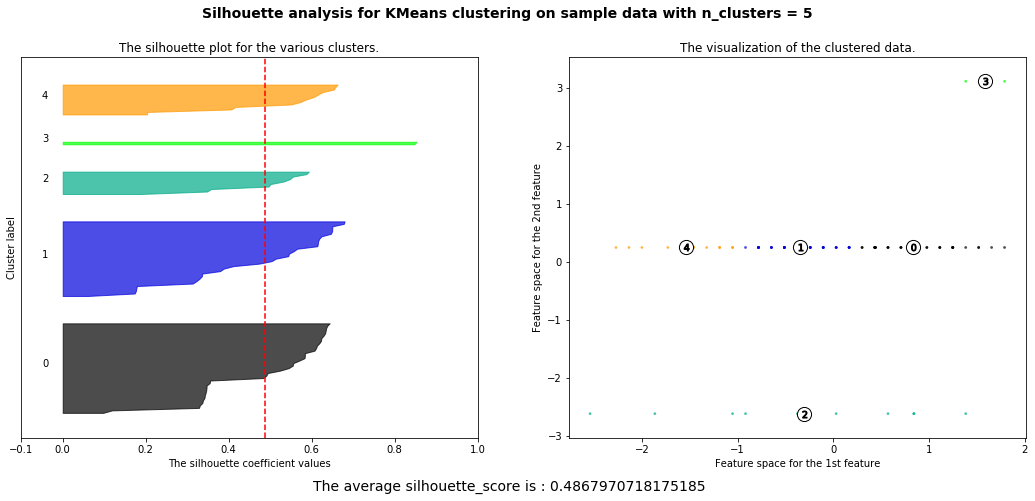

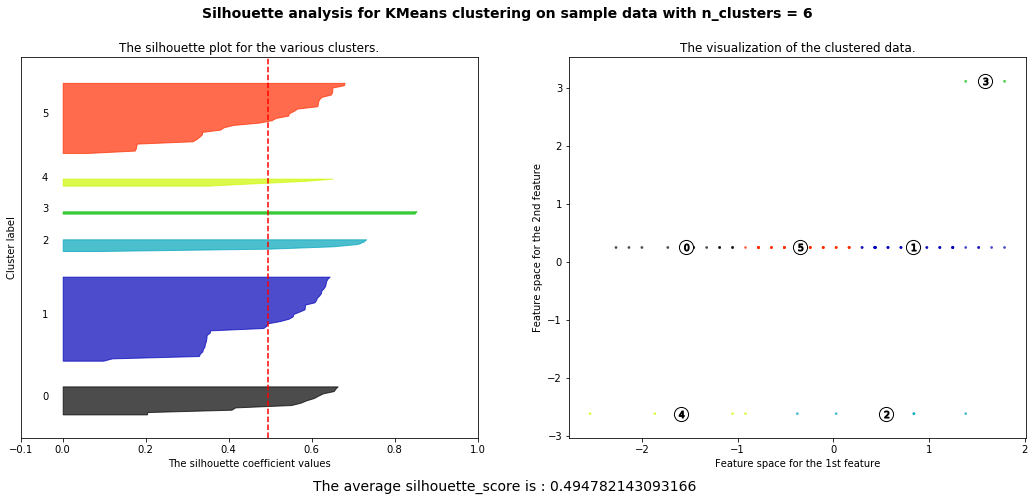

In [45]:
from sklearn.metrics import silhouette_samples, silhouette_score

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(thai_res_nyc_cluster_scaled) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(thai_res_nyc_cluster_scaled)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(thai_res_nyc_cluster_scaled, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(thai_res_nyc_cluster_scaled, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors_cluster = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(thai_res_nyc_cluster_scaled.Rating.values, thai_res_nyc_cluster_scaled.Price_tier.values, marker='.', s=30, lw=0, alpha=0.7,
                c=colors_cluster, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.figtext(0.35, 0.02, f'The average silhouette_score is : {silhouette_avg}', fontsize = 14)
    
    
    fig.savefig(f'Silhouette plot on scaled data_{n_clusters}.png')

plt.show()


#### Silhouette plot on scaled all features data

For n_clusters = 2 The average silhouette_score is : 0.018497696187746982
For n_clusters = 3 The average silhouette_score is : 0.03576912530646238
For n_clusters = 4 The average silhouette_score is : 0.04543757495637257
For n_clusters = 5 The average silhouette_score is : 0.07140526508359249
For n_clusters = 6 The average silhouette_score is : 0.06030174596939971


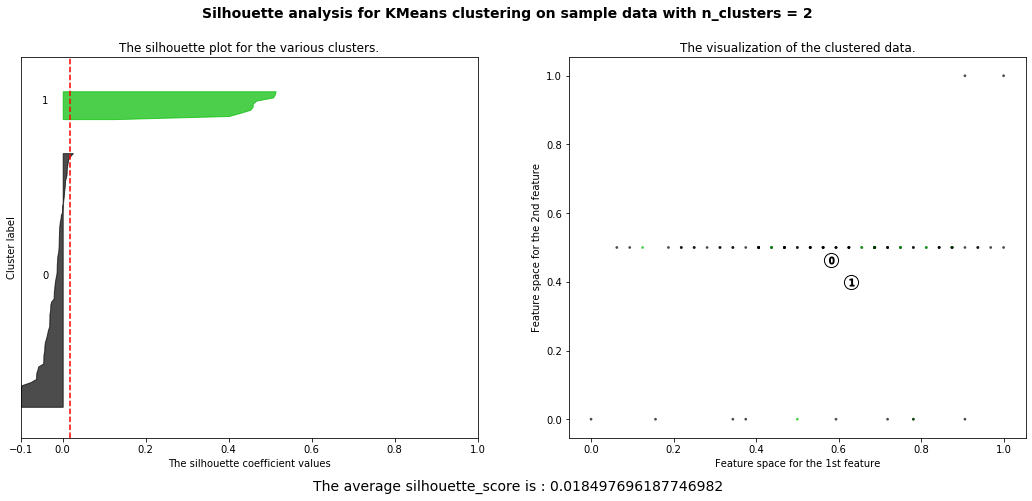

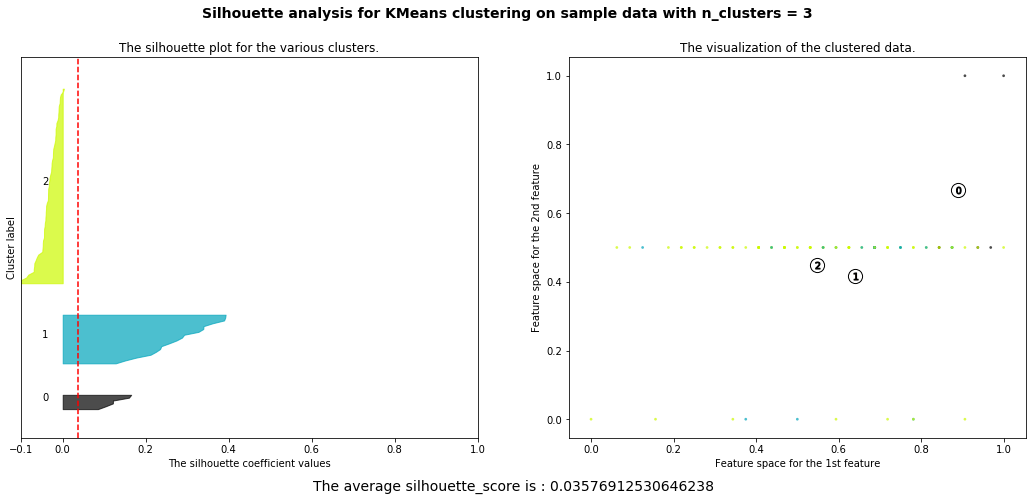

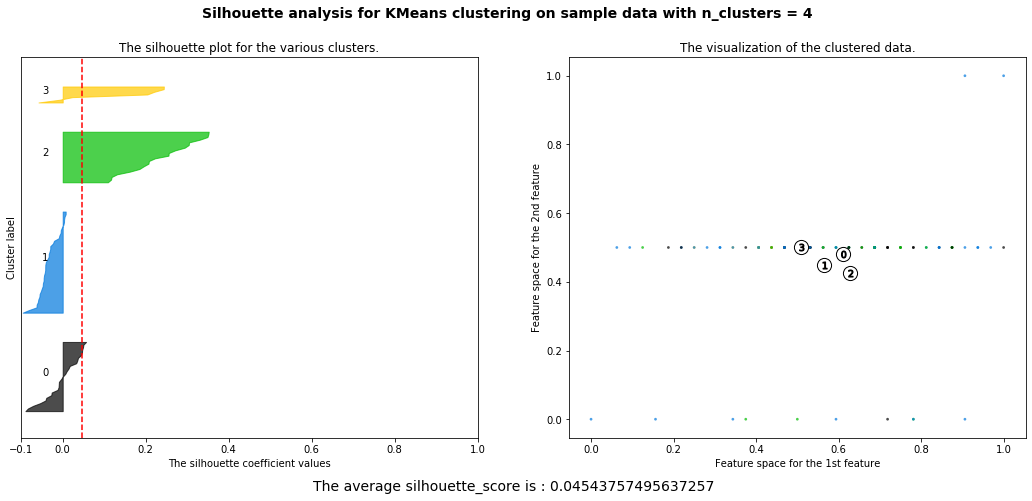

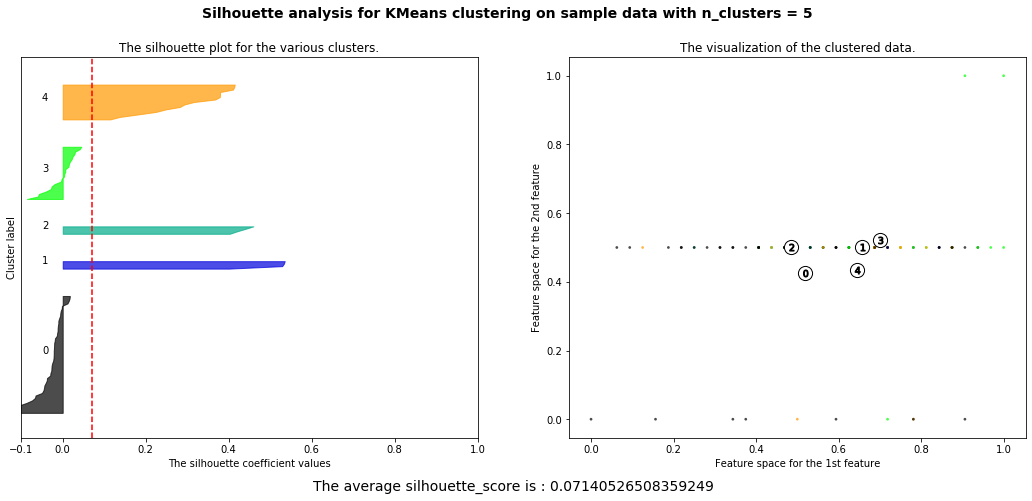

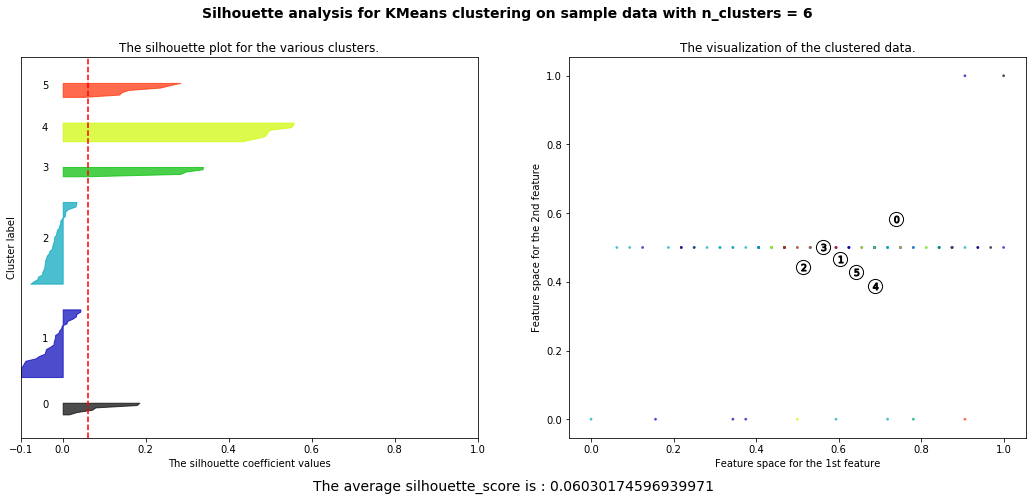

In [46]:
from sklearn.metrics import silhouette_samples, silhouette_score

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(thai_res_nyc_cluster_scaled_all_features) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(thai_res_nyc_cluster_scaled_all_features)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(thai_res_nyc_cluster_scaled_all_features, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(thai_res_nyc_cluster_scaled_all_features, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors_cluster = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(thai_res_nyc_cluster_scaled_all_features.Rating.values, thai_res_nyc_cluster_scaled_all_features.Price_tier.values, marker='.', s=30, lw=0, alpha=0.7,
                c=colors_cluster, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.figtext(0.35, 0.02, f'The average silhouette_score is : {silhouette_avg}', fontsize = 14)
    
    
    fig.savefig(f'Silhouette plot on scaled all features data_{n_clusters}.png')

plt.show()

After we examined the result of the Elbow method and Silhouette plot, we found that Using **K = 4** on scaled some feature data Should produce the best understanding results

#### Clustering

In [47]:
df_for_clusting = thai_res_nyc_cluster_scaled.copy()

In [48]:
# set number of clusters
kclusters = 4


# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_for_clusting)

In [49]:
# add clustering labels
thai_res_nyc_clustered = thai_res_nyc_merged.copy()

thai_res_nyc_clustered.insert(0, 'Cluster Labels', kmeans.labels_)

thai_res_nyc_clustered.head()

,Cluster Labels,ID,Name,Borough,Neighborhood,Venue_lat,Venue_lng,Likes,Rating,Tips,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,2,4b94a4a2f964a520787f34e3,Nam Thai,Bronx,Riverdale,40.886388,-73.910025,3.0,7.1,5.0,...,Pizza Place,Mexican Restaurant,Diner,Bar,Coffee Shop,Japanese Restaurant,Bank,Sandwich Place,Bagel Shop,Burger Joint
1,2,4a739e29f964a520f5dc1fe3,Siam Square,Manhattan,Marble Hill,40.878796,-73.916701,15.0,7.3,13.0,...,Donut Shop,Pizza Place,Park,Coffee Shop,Sandwich Place,Deli / Bodega,Wine Shop,Pharmacy,Gym,Mexican Restaurant
2,1,4b4c90d3f964a52046b626e3,Honey's Thai Pavilion,Bronx,Country Club,40.847845,-73.831320,19.0,7.3,27.0,...,Italian Restaurant,Sandwich Place,Bank,Convenience Store,Bakery,Pharmacy,Donut Shop,Pizza Place,Dive Bar,Gym
3,2,5585c948498e0bd8a8a706f1,Thai Cuisine,Bronx,Parkchester,40.838048,-73.863917,17.0,7.2,1.0,...,Pizza Place,Donut Shop,American Restaurant,Latin American Restaurant,Mobile Phone Shop,Supermarket,Coffee Shop,Kids Store,Bar,Bank
4,2,50e8d45ae4b06202fbe39b08,Top Thai,Brooklyn,Bay Ridge,40.623236,-74.028173,14.0,7.2,11.0,...,Spa,Pizza Place,Cosmetics Shop,Middle Eastern Restaurant,Greek Restaurant,Bakery,Japanese Restaurant,Italian Restaurant,Tea Room,Taco Place


#### Visualize Cluster

In [50]:
# create map
map_clusters = folium.Map(location=[40.71306007524032, -73.94420151920066], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lng, rating, price, cluster in zip(thai_res_nyc_clustered['Venue_lat'], thai_res_nyc_clustered['Venue_lng'], thai_res_nyc_clustered['Rating'], thai_res_nyc_clustered['Price_message'], thai_res_nyc_clustered['Cluster Labels']):
    label = folium.Popup(f"rating: {rating} </br> price: {price}", parse_html=True)
    html="""
    <h2><center>Cluster: {0}</center></h2>
    <h4>Rating: {1}</h4>
    <h4>Price: {2}</h4>
    """.format(cluster, rating, price)
    iframe = folium.IFrame(html=html, width=170, height=135)
    popup = folium.Popup(iframe, max_width=170)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=popup,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [ ]:
map_clusters.save('cluster_map.html')

## 4. Analysis <a name="analysis"></a>

### Cluster 0

In [51]:
cluster_0 = thai_res_nyc_clustered.loc[thai_res_nyc_clustered['Cluster Labels'] == 0, thai_res_nyc_clustered.columns[[2, 8, 10] + list(range(12, thai_res_nyc_clustered.shape[1]))]]
cluster_0.head(10)

,Name,Rating,Price_message,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Ruammit Thai,8.5,Moderate,Coffee Shop,Café,Bakery,Cocktail Bar,Pizza Place,Sushi Restaurant,Bagel Shop,Indian Restaurant,Yoga Studio,Mexican Restaurant
8,Sawasde Thai Cooking,8.5,Moderate,Thai Restaurant,Café,Grocery Store,Coffee Shop,Ice Cream Shop,Donut Shop,Playground,Wine Shop,Pizza Place,Mexican Restaurant
9,Thai Farm Kitchen,8.9,Moderate,Bar,Thai Restaurant,Café,Wine Shop,Middle Eastern Restaurant,Mexican Restaurant,Grocery Store,Pizza Place,Coffee Shop,Liquor Store
16,Noods n’ Chill,8.4,Moderate,Coffee Shop,Wine Bar,Bakery,Yoga Studio,Salon / Barbershop,Pizza Place,Sushi Restaurant,Cocktail Bar,Music Venue,Latin American Restaurant
17,Klom Klorm,8.7,Moderate,Bar,Mexican Restaurant,Bakery,Coffee Shop,Pizza Place,Taco Place,Deli / Bodega,Brewery,Theater,Gym
20,Joya,8.2,Moderate,Bakery,Cocktail Bar,Bagel Shop,Optical Shop,Bar,Coffee Shop,Dessert Shop,Gift Shop,Gym / Fitness Center,Kitchen Supply Store
21,Ugly Baby,8.8,Moderate,Coffee Shop,Bar,Pizza Place,Wine Shop,Italian Restaurant,Record Shop,Brewery,Furniture / Home Store,Spa,Butcher
22,Boran,8.2,Moderate,Coffee Shop,Pizza Place,Italian Restaurant,Yoga Studio,Brewery,Furniture / Home Store,Bar,Record Shop,Wine Shop,Restaurant
23,Somtum Der,8.4,Moderate,Bar,Park,Seafood Restaurant,Wine Shop,Brewery,Farm,Sandwich Place,Flower Shop,Ice Cream Shop,Pizza Place
24,Thaiholic,8.6,Moderate,Italian Restaurant,Coffee Shop,Wine Shop,Thai Restaurant,Yoga Studio,Cocktail Bar,Optical Shop,Convenience Store,Farmers Market,Bar


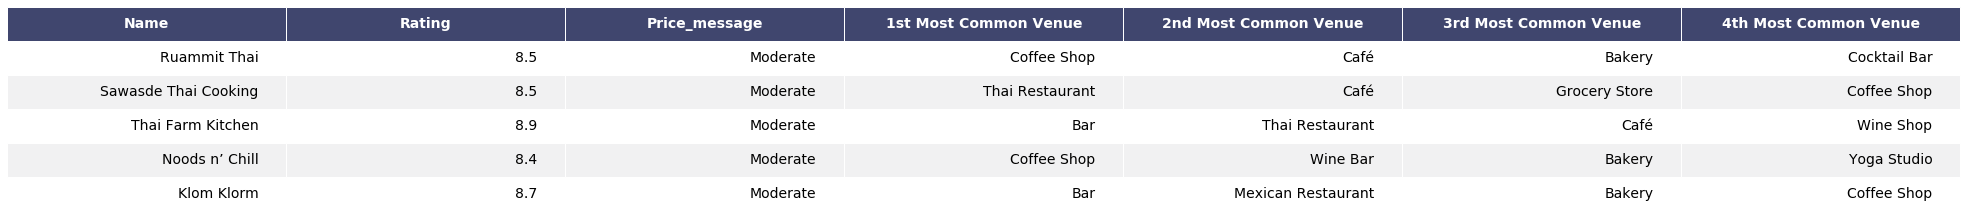

In [52]:
ax = render_mpl_table(cluster_0.iloc[0:5,0:7], header_columns=0, col_width=5.0)
fig = ax.get_figure()
fig.savefig('cluster_0.png')

### Cluster 1

In [53]:
cluster_1 = thai_res_nyc_clustered.loc[thai_res_nyc_clustered['Cluster Labels'] == 1, thai_res_nyc_clustered.columns[[2, 8, 10] + list(range(12, thai_res_nyc_clustered.shape[1]))]]
cluster_1.head(10)

,Name,Rating,Price_message,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Honey's Thai Pavilion,7.3,Cheap,Italian Restaurant,Sandwich Place,Bank,Convenience Store,Bakery,Pharmacy,Donut Shop,Pizza Place,Dive Bar,Gym
13,LOOK by Plant Love House,8.5,Cheap,Bar,Wine Shop,Cocktail Bar,Coffee Shop,Ice Cream Shop,Wine Bar,Bakery,Café,Mexican Restaurant,Caribbean Restaurant
26,Song Thai Restaurant & Bar,8.1,Cheap,Coffee Shop,Bar,Park,American Restaurant,Bakery,Café,Cocktail Bar,Seafood Restaurant,Caribbean Restaurant,Yoga Studio
53,Sweet Basil,7.4,Cheap,Bar,Bakery,American Restaurant,Thai Restaurant,Latin American Restaurant,Filipino Restaurant,Pub,Gym,Grocery Store,Chinese Restaurant
59,Eim Khao Mun Kai Elmhurst อิ่ม ข้าวมันไก่เอ็มเ...,8.7,Cheap,Thai Restaurant,Mexican Restaurant,Food Truck,Indonesian Restaurant,Vietnamese Restaurant,Chinese Restaurant,Argentinian Restaurant,South American Restaurant,Pizza Place,Cajun / Creole Restaurant
67,Boon Chu Thai Restaurant,7.8,Cheap,Thai Restaurant,Chinese Restaurant,Bakery,Pizza Place,Bubble Tea Shop,Mexican Restaurant,Sushi Restaurant,Indonesian Restaurant,Argentinian Restaurant,Vietnamese Restaurant
68,Bangkok Cuisine,8.7,Cheap,Bakery,Yoga Studio,Pizza Place,Cosmetics Shop,Seafood Restaurant,Food Truck,Boxing Gym,Sushi Restaurant,Burger Joint,Health & Beauty Service
71,Thai Pot,6.2,Cheap,Yoga Studio,Middle Eastern Restaurant,Burger Joint,Snack Place,Bagel Shop,Sushi Restaurant,Park,Boxing Gym,Liquor Store,Coffee Shop
77,Asian Bowl Thai Cuisine,6.7,Cheap,Indian Restaurant,Pharmacy,Intersection,Grocery Store,Mobile Phone Shop,Food Truck,Hookah Bar,Sandwich Place,School,Farm
83,Pye Boat Noodle,9.1,Cheap,Bar,Bagel Shop,Pizza Place,Cocktail Bar,Café,Greek Restaurant,Thai Restaurant,Sushi Restaurant,Bookstore,Gift Shop


C:\Users\kitit\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 3629 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\kitit\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 3636 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\kitit\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 3656 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\kitit\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 3617 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\kitit\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 3586 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\kitit\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 3657 missing from current

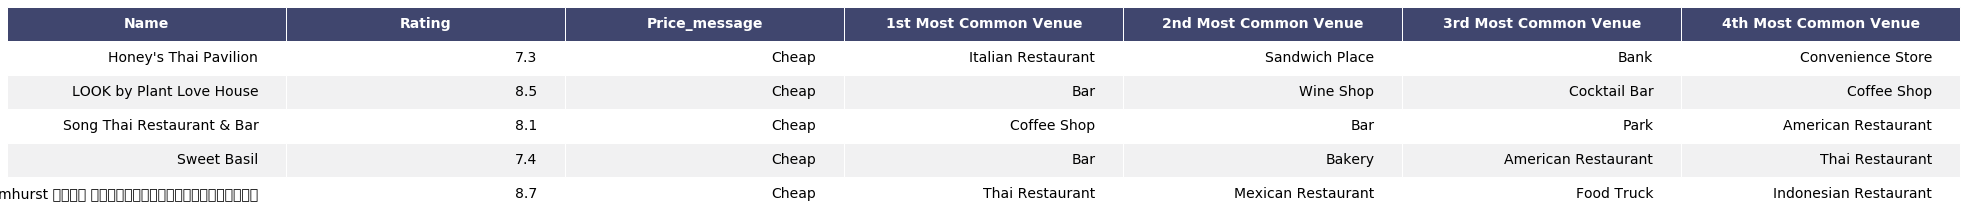

In [54]:
ax = render_mpl_table(cluster_1.iloc[0:5,0:7], header_columns=0, col_width=5.0)
fig = ax.get_figure()
fig.savefig('cluster_1.png')

### Cluster 2

In [55]:
cluster_2 = thai_res_nyc_clustered.loc[thai_res_nyc_clustered['Cluster Labels'] == 2, thai_res_nyc_clustered.columns[[2, 8, 10] + list(range(12, thai_res_nyc_clustered.shape[1]))]]
cluster_2.head(10)

,Name,Rating,Price_message,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Nam Thai,7.1,Moderate,Pizza Place,Mexican Restaurant,Diner,Bar,Coffee Shop,Japanese Restaurant,Bank,Sandwich Place,Bagel Shop,Burger Joint
1,Siam Square,7.3,Moderate,Donut Shop,Pizza Place,Park,Coffee Shop,Sandwich Place,Deli / Bodega,Wine Shop,Pharmacy,Gym,Mexican Restaurant
3,Thai Cuisine,7.2,Moderate,Pizza Place,Donut Shop,American Restaurant,Latin American Restaurant,Mobile Phone Shop,Supermarket,Coffee Shop,Kids Store,Bar,Bank
4,Top Thai,7.2,Moderate,Spa,Pizza Place,Cosmetics Shop,Middle Eastern Restaurant,Greek Restaurant,Bakery,Japanese Restaurant,Italian Restaurant,Tea Room,Taco Place
5,Mai Thai,6.6,Moderate,Chinese Restaurant,Latin American Restaurant,Bakery,Café,Mexican Restaurant,Szechuan Restaurant,Asian Restaurant,Tea Room,Dumpling Restaurant,Pizza Place
6,Mondayoff By Plant Love House,7.5,Moderate,Mexican Restaurant,Coffee Shop,Bar,Pizza Place,Burger Joint,Health Food Store,Café,Farmers Market,Filipino Restaurant,Tapas Restaurant
10,To Be Thai,7.9,Moderate,Thai Restaurant,Café,Mexican Restaurant,Coffee Shop,Nail Salon,Grocery Store,Ice Cream Shop,Pizza Place,Burger Joint,Pharmacy
11,AM Thai Bistro,7.9,Moderate,Wine Shop,Thai Restaurant,Bar,Café,Coffee Shop,Middle Eastern Restaurant,Playground,Grocery Store,Burger Joint,Tennis Court
12,Jai Dee Thai Restaurant,7.5,Moderate,Italian Restaurant,Bar,Wine Shop,Café,Gym,Bakery,Coffee Shop,American Restaurant,Vietnamese Restaurant,Sushi Restaurant
14,Muse,7.8,Moderate,Bar,Coffee Shop,Cocktail Bar,Beer Bar,Ice Cream Shop,Mexican Restaurant,Wine Bar,Wine Shop,Sushi Restaurant,Garden Center


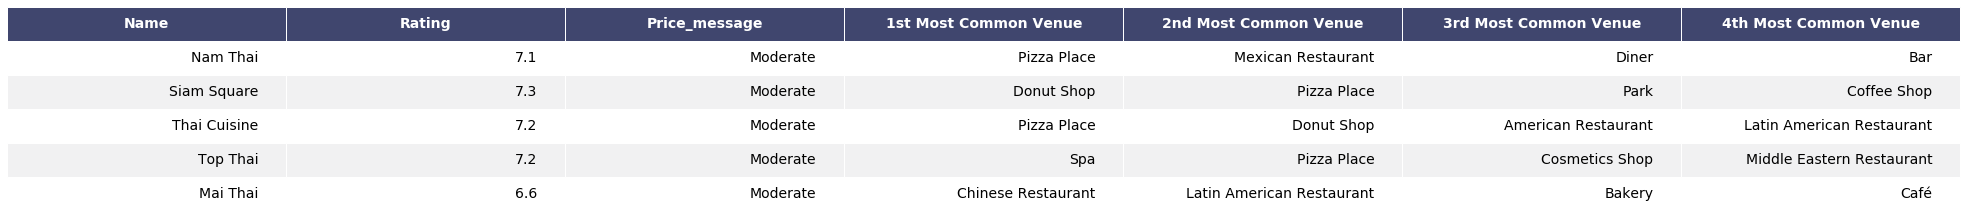

In [56]:
ax = render_mpl_table(cluster_2.iloc[0:5,0:7], header_columns=0, col_width=5.0)
fig = ax.get_figure()
fig.savefig('cluster_2.png')

### Cluster 3

In [57]:
cluster_3 = thai_res_nyc_clustered.loc[thai_res_nyc_clustered['Cluster Labels'] == 3, thai_res_nyc_clustered.columns[[2, 8, 10] + list(range(12, thai_res_nyc_clustered.shape[1]))]]
cluster_3.head(10)

,Name,Rating,Price_message,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
88,Fish Cheeks,9.4,Expensive,Italian Restaurant,Spa,Bookstore,Yoga Studio,Wine Shop,Pizza Place,Cosmetics Shop,Gym,Gym / Fitness Center,Sushi Restaurant
91,Thai Villa,9.1,Expensive,American Restaurant,Japanese Restaurant,Cycle Studio,Gym / Fitness Center,Furniture / Home Store,Café,New American Restaurant,Burger Joint,Juice Bar,Clothing Store


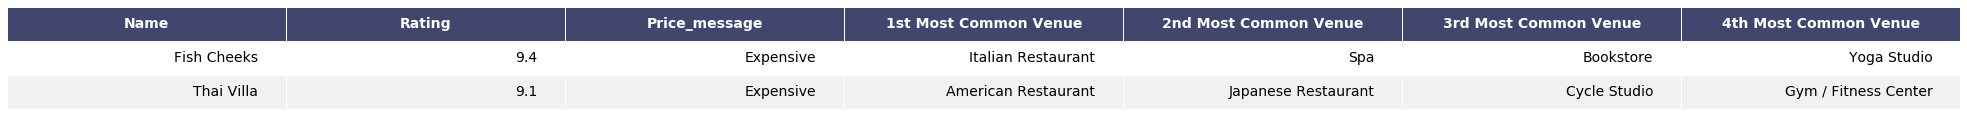

In [58]:
ax = render_mpl_table(cluster_3.iloc[0:5,0:7], header_columns=0, col_width=5.0)
fig = ax.get_figure()
fig.savefig('cluster_3.png')

### Visualize cluster and exploratory analysis

In [59]:
# create map
map_clusters = folium.Map(location=[40.71306007524032, -73.94420151920066], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lng, rating, price, cluster in zip(thai_res_nyc_clustered['Venue_lat'], thai_res_nyc_clustered['Venue_lng'], thai_res_nyc_clustered['Rating'], thai_res_nyc_clustered['Price_message'], thai_res_nyc_clustered['Cluster Labels']):
    label = folium.Popup(f"rating: {rating} </br> price: {price}", parse_html=True)
    html="""
    <h2><center>Cluster: {0}</center></h2>
    <h4>Rating: {1}</h4>
    <h4>Price: {2}</h4>
    """.format(cluster, rating, price)
    iframe = folium.IFrame(html=html, width=170, height=135)
    popup = folium.Popup(iframe, max_width=170)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=popup,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
ls = folium.PolyLine([[40.74,-74.00],[40.74,-73.97],[40.77,-73.97],[40.77,-74.00],[40.74,-74.00]], color='red')
ls.add_child(folium.Popup("outline Popup on Polyline"))
ls.add_to(map_clusters)
        
map_clusters

In [60]:
map_clusters.save('cluster_map_with_polyline.html')

## 5. Results and Discussion <a name="results"></a>

The objective of this business problem was to help stakeholders identify a location for the opening of a Thai restaurant in NYC and an appropriate price range (also a common nearby venue) within the Thai Restaurants to set up a commercial establishment especially a Restaurants.

This has been achieved by first making use of “IBM dataset” containing the New York information to identify where is a Thai restaurant. Then use FoursquareAPI to get additional information about Thai Restaurant. After finding the restaurant it was imperative to choose the right neighborhood where that restaurant was not among venues in close proximity to each other (lack of).

I achieved this by grouping the Thai restaurant into clusters to assist the stakeholders by providing them with relevant data about venues of a given neighborhood.

## 6. Conclusion <a name="conclusion"></a>

I have explored the IBM data and FoursquareAPI to understand different types of Thai restaurant in all neighborhoods of NYC and later categorized them into a different cluster with their characteristics, this helped us group the Thai restaurant into a group of price and common nearby venues.

Once I confirmed the are the number of the cluster for consideration also comes down, I further shortlist the cluster based on the exploratory analysis, to choose the best location which best suits the business problem.

In summary, these 5 neighborhood are lack of Thai restaurant (Manhattan: Gramercy, Clinton, Midtown-Midtown South, Murray Hill-Kips Bay, Hudson Yards-Chelsea-Flatiron-Union Square) and the price range of these 5 areas is Moderate.